In [3]:
#importing necessary header files
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import csv

In [4]:
#reading messages from text files 
messages = pd.read_csv('/home/abhishek/projects/smsspamcollection/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"])

In [5]:
print messages.head()

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [6]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
#function to split the words 
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [8]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [9]:
#just applying functions in messages and we could see that the words are seperated by commas
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [10]:
#Sample textblob example
TextBlob("Hello world, how is it going?").tags

[('Hello', u'NNP'),
 ('world', u'NN'),
 ('how', u'WRB'),
 ('is', u'VBZ'),
 ('it', u'PRP'),
 ('going', u'VBG')]

In [11]:
#lemmatisation is done using this block
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [12]:
#lemmatisation is applied in messages
messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [13]:
#transformation function is defined , We will be using this for every message we want to predict 
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)

8859


In [14]:
# create a dummy message for checking the prediction
message4="Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [15]:
bow4 = bow_transformer.transform([message4])
print bow4.shape

(1, 8859)


In [16]:
#transforming all the messages into vectors

messages_bow = bow_transformer.transform(messages['message'])

#Now applying tfidf to messages
tfidf_transformer = TfidfTransformer().fit(messages_bow)


In [17]:
#transforming all messages to tfidf
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5574, 8859)


In [18]:
#for all text of sample message i.e message4 ,the values are displayed here 
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8510)	0.179717734319
  (0, 8470)	0.138255998507
  (0, 7985)	0.118223913422
  (0, 7801)	0.171093569709
  (0, 7790)	0.208257801644
  (0, 7637)	0.112951857566
  (0, 7523)	0.130175310876
  (0, 7300)	0.185514621941
  (0, 6398)	0.157706385794
  (0, 6340)	0.157706385794
  (0, 6287)	0.158459432399
  (0, 5019)	0.148440581089
  (0, 4179)	0.0764459636852
  (0, 3433)	0.109137326222
  (0, 3283)	0.173576758371
  (0, 3173)	0.44305635446
  (0, 3042)	0.339536501956
  (0, 2476)	0.190251024
  (0, 2263)	0.185514621941
  (0, 1897)	0.119727899914
  (0, 1272)	0.160034356333
  (0, 948)	0.0644277962218
  (0, 893)	0.208257801644
  (0, 484)	0.214054689266
  (0, 472)	0.214054689266
  (0, 452)	0.0944852751958
  (0, 103)	0.22152817723
  (0, 21)	0.183770556409


In [19]:
#creating a detector using mutinomial NB 
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

In [20]:
#for the given sample messsage the prediction is tested ! hence it is spam
%time print 'predicted:', spam_detector.predict(tfidf4)[0]

predicted: spam
CPU times: user 925 µs, sys: 27 µs, total: 952 µs
Wall time: 3.07 ms


In [21]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

# accuracy
print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']
accuracy 0.969501255831
confusion matrix
[[4827    0]
 [ 170  577]]


In [22]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



In [23]:
#Now we are trying the same using SGD alogorithm to validate whether the performance is improved 

from sklearn.linear_model import SGDClassifier

In [24]:
#creating classifier function
clf = SGDClassifier(loss="log", random_state=1, n_iter=1)

In [25]:
#Creating detecting system using the SGD classifier we defined previously 
spamdetectsgd = clf.fit(messages_tfidf, messages['label'])

/home/abhishek/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [26]:
allscg_predictions = spamdetectsgd.predict(messages_tfidf)
print allscg_predictions

# accuracy
print 'accuracy', accuracy_score(messages['label'], allscg_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], allscg_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']
accuracy 0.988338715465
confusion matrix
[[4824    3]
 [  62  685]]


In [27]:
#we can see the performance is improved and it is around 99 % 




#sample tests messages are created below to detect how well our alogorithm works , 
#BTW all the messages below are spam messages     #lets check our system identifies it or not . 
#All these below messages are entered in text file and made to read 

In [38]:
messagestest = pd.read_csv('/home/abhishek/projects/smsspamcollection/checkmsgs', sep='\t', quoting=csv.QUOTE_NONE,names=["label","message"])

In [39]:
messagestest

,label,message
0,spam,"IMPORTANT - You could be entitled up to £3,160..."
1,spam,A [redacted] loan for £950 is approved for you...
2,spam,You have still not claimed the compensation yo...
3,spam,Our records indicate your Pension is under per...


In [40]:
#dropping the label 
messagestest = messagestest.drop("label",axis=1)

In [41]:
messagestest

,message
0,"IMPORTANT - You could be entitled up to £3,160..."
1,A [redacted] loan for £950 is approved for you...
2,You have still not claimed the compensation yo...
3,Our records indicate your Pension is under per...


In [42]:
messagesstestbow = bow_transformer.transform(messagestest['message'])

In [43]:
#Now applying tfidf to messages
tfidf_transformer = TfidfTransformer().fit(messagesstestbow)

In [44]:
allscg_predictions = spamdetectsgd.predict(messagesstestbow)
print allscg_predictions


['spam' 'spam' 'spam' 'spam']


In [45]:
#therefore we got the prediction stating all are spam 

In [46]:
#importing header to display words which are spam
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from math import log ,sqrt

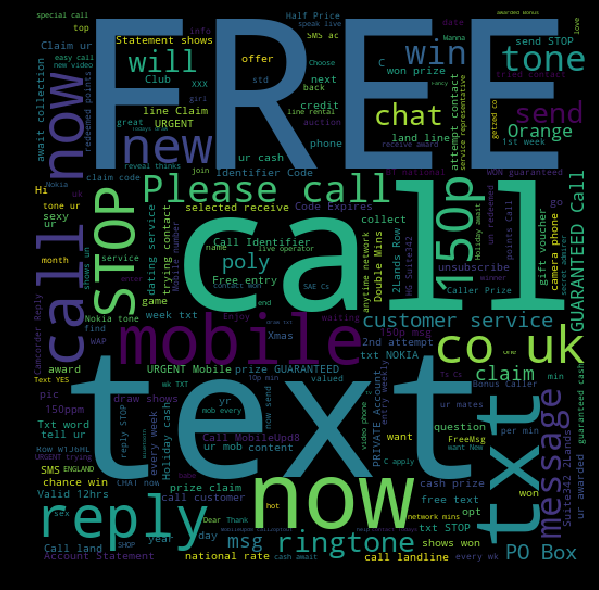

In [48]:
#generating figure which displayes SPAM words 
spam_words = ' '.join(list(messages[messages['label']=='spam']['message']))
spamwc = WordCloud(width = 512 , height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

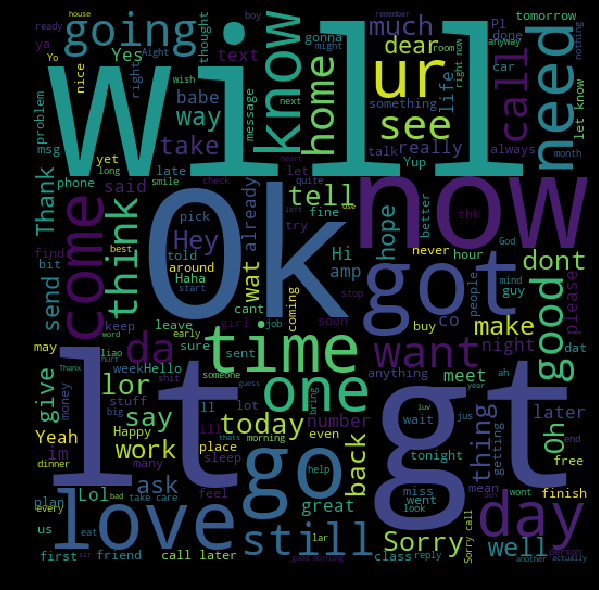

In [49]:
#generating figure which displayes HAM words 
ham_words = ' '.join(list(messages[messages['label']=='ham']['message']))
spamwc = WordCloud(width = 512 , height = 512).generate(ham_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()